# Práctica 3



**Autores**: José Antonio Álvarez, Ivonne Aparicio, Sara Casado, Álvaro Madroñal y Javier Pardo

**Grupo**: 3ºC

##Importar Librerias


In [ ]:
!pip install torch torchvision
!pip install tensorflow
!pip install kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.model_selection import KFold
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
!pip install pandas
import pandas as pd



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

##Descarga del dataset


Se cuenta el número de imagenes de cada clase para asegurarnos que no hay un desbalanceo entre las clases


In [ ]:
# Descarga el dataset de kaggle
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

# Definimos las rutas de los diferentes conjuntos de datos, en este caso, para el entrenamiento, test y validación, por lo que no es necesario hacer división del dataset
chest_xray_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(chest_xray_dir, "train") #Dataset para el entrenamiento
test_dir = os.path.join(chest_xray_dir, "test") #Dataset para el test
val_dir = os.path.join(chest_xray_dir, "val") #Dataset para la validación

#Contamos el número de imágenes que hay en cada clase para asegurar que no hay desbalanceo de clases
def count_images_in_folder(folder_path):
    """Cuenta las imágenes (archivos con extensiones de imagen) en una carpeta dada."""
    valid_exts = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
    if not os.path.isdir(folder_path):
        return 0
    return sum(f.lower().endswith(valid_exts) for f in os.listdir(folder_path))

# Contar en train
normal_train_dir = os.path.join(train_dir, "NORMAL")
pneumonia_train_dir = os.path.join(train_dir, "PNEUMONIA")
normal_train_count = count_images_in_folder(normal_train_dir)
pneumonia_train_count = count_images_in_folder(pneumonia_train_dir)
print("=== TRAIN ===")
print(f"  NORMAL: {normal_train_count}")
print(f"  PNEUMONIA: {pneumonia_train_count}")
print(f"  TOTAL: {normal_train_count + pneumonia_train_count}")




Path to dataset files: /kaggle/input/chest-xray-pneumonia
=== TRAIN ===
  NORMAL: 1341
  PNEUMONIA: 3875
  TOTAL: 5216


##Asignación de Parametros de las imagénes


In [ ]:

img_size = (128, 128) #Dimensión de la imagen
batch_size = 32 #Dimensionalidad del batch

##Funciones para cargar las imágenes de los directorios y crear el dataset


In [ ]:
#Función para cargar las imagenes y preprocesarlas del dataset de kaggle
def load_and_preprocess_classifier(path, label, num_classes):
    # Lee el archivo de imagen desde la ruta especificada
    image = tf.io.read_file(path)

    # Decodifica la imagen JPEG en un tensor con 3 canales (RGB)
    image = tf.image.decode_jpeg(image, channels=3)

    # Redimensiona la imagen al tamaño predefinido en img_size
    # Nota: img_size debe estar definido previamente o pasarse como parámetro
    image = tf.image.resize(image, img_size)

    # Normaliza los valores de píxeles al rango [0,1] dividiendo por 255
    image = image / 255.0

    # Convierte la etiqueta numérica a una representación one-hot
    # Por ejemplo, si label=2 y num_classes=5, esto generará [0,0,1,0,0]
    label = tf.one_hot(label, depth=num_classes)

    # Devuelve la imagen procesada y la etiqueta codificada
    return image, label

def create_classifier_dataset(file_paths, labels, num_classes, is_training=True):
    # Crea un dataset a partir de listas de rutas de archivos y sus etiquetas correspondientes
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Aplica la función de preprocesamiento a cada elemento del dataset
    # num_parallel_calls=AUTOTUNE permite a TensorFlow optimizar la paralelización
    ds = ds.map(lambda x, y: load_and_preprocess_classifier(x, y, num_classes),
                num_parallel_calls=tf.data.AUTOTUNE)

    # Si estamos en modo entrenamiento, mezcla aleatoriamente los datos
    # Esto es importante para evitar que el modelo aprenda el orden de los datos
    if is_training:
        ds = ds.shuffle(buffer_size=1000)

    # Agrupa los datos en lotes (batches) del tamaño especificado en la variable batch_size
    # y prefetch optimiza el rendimiento al preparar datos mientras el modelo procesa el lote actual
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Retorna el dataset configurado y listo para ser utilizado en entrenamiento o evaluación
    return ds


Se aplica Data Augmentation para crear imágenes artificiales y tener más imágenes

In [ ]:
data_augmentation = tf.keras.Sequential([
    # Voltea aleatoriamente las imágenes horizontalmente (de izquierda a derecha)
    # Esto ayuda al modelo a generalizar independientemente de la orientación horizontal
    layers.RandomFlip("horizontal"),

    # Rota aleatoriamente las imágenes hasta 20% (0.2) en sentido horario o antihorario
    # Ayuda al modelo a reconocer objetos con diferentes orientaciones
    layers.RandomRotation(0.2),

    # Aplica zoom aleatorio de hasta 20% (acercando o alejando)
    # Ayuda al modelo a reconocer objetos a diferentes escalas
    layers.RandomZoom(0.2),

    # Desplaza aleatoriamente las imágenes hasta un 10% horizontal y verticalmente
    # Ayuda al modelo a reconocer objetos independientemente de su posición en la imagen
    layers.RandomTranslation(0.1, 0.1)
])


##Función para hacer gráfica de accuracy y loss


In [ ]:
def plot_training_history(history):
    # Importa la biblioteca matplotlib para crear gráficos
    import matplotlib.pyplot as plt

    # Crea un rango de valores que representan el número de épocas, comenzando en 1
    epochs = range(1, len(history.history['loss']) + 1)

    # Crea una figura con un tamaño específico (14x6 pulgadas)
    plt.figure(figsize=(14,6))

    # Primer gráfico: Loss (pérdida) durante el entrenamiento
    plt.subplot(1,2,1)  # Crea una cuadrícula 1x2 y selecciona la primera posición

    # Grafica la pérdida de entrenamiento con marcadores circulares
    plt.plot(epochs, history.history['loss'], marker='o', label='Training Loss')

    # Grafica la pérdida de validación con marcadores circulares
    plt.plot(epochs, history.history['val_loss'], marker='o', label='Validation Loss')

    # Añade título y etiquetas a los ejes
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Añade una leyenda y una cuadrícula para mejorar la legibilidad
    plt.legend()
    plt.grid(True)

    # Segundo gráfico: Accuracy (precisión) durante el entrenamiento
    plt.subplot(1,2,2)  # Selecciona la segunda posición en la cuadrícula

    # Grafica la precisión de entrenamiento con marcadores circulares
    plt.plot(epochs, history.history['accuracy'], marker='o', label='Training Accuracy')

    # Grafica la precisión de validación con marcadores circulares
    plt.plot(epochs, history.history['val_accuracy'], marker='o', label='Validation Accuracy')

    # Añade título y etiquetas a los ejes
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Añade una leyenda y una cuadrícula para mejorar la legibilidad
    plt.legend()
    plt.grid(True)

    # Ajusta automáticamente el espaciado entre subgráficos
    plt.tight_layout()

    # Muestra la figura con los dos gráficos
    plt.show()

##Arquitectura de la primera CNN (Diferencia entre pneumonia O normal)


In [ ]:
# ===============================
# Modelo CNN: clasificacion de PNEUMONIA vs NORMAL
# ===============================

def build_classifier_model(num_classes):
    # Crea un modelo secuencial de Keras
    model = tf.keras.Sequential([
        # Define la forma de entrada del modelo según el tamaño de imagen predefinido
        # con 3 canales de color (RGB)
        tf.keras.Input(shape=(img_size[0], img_size[1], 3)),

        # Primera capa convolucional con 32 filtros de tamaño 3x3 y función de activación ReLU, que extrae las caracteristicas basicas de bordes y texturas
        layers.Conv2D(32, (3,3), activation='relu'),

        # Capa de MaxPooling que reduce la dimensionalidad espacial a la mitad
        layers.MaxPooling2D((2,2)),

        # Segunda capa convolucional con 64 filtros
        layers.Conv2D(64, (3,3), activation='relu'),

        # Segunda capa de MaxPooling
        layers.MaxPooling2D((2,2)),

        # Tercera capa convolucional con 128 filtros
        layers.Conv2D(128, (3,3), activation='relu'),

        # Tercera capa de MaxPooling
        layers.MaxPooling2D((2,2)),

        # Capa de aplanamiento que convierte los mapas de características 2D en un vector 1D, fully conected
        layers.Flatten(),

        # Primera capa densa con 128 neuronas
        layers.Dense(128, activation='relu'),

        # Capa de salida con tantas neuronas como clases haya
        layers.Dense(num_classes, activation='softmax')
    ])

    #Se compila el modelo con diferentes hiperparametros
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Devuelve el modelo configurado listo para entrenamiento
    return model


##Arquitectura de la segunda CNN (Diferencia entre pneumonia bacteriana, pneuomonia vírica y normal)

In [ ]:
# ===============================
# Modelo CNN: clasificacion de VÍRICA O BACTERIANA
# ===============================
def build_classifier_model_subtype(num_classes):

    # Crea un modelo secuencial de Keras (capas apiladas linealmente)
    model = tf.keras.Sequential([
        # Define la forma de entrada del modelo con 3 canales de entrada, ya que las imágenes son RGB
        tf.keras.Input(shape=(img_size[0], img_size[1], 3)),

        # Primera capa convolucional con 32 filtros de tamaño 3x3 y función de activación ReLU
        layers.Conv2D(32, (3,3), activation='relu'),

        # Capa de MaxPooling que reduce la dimensionalidad espacial a la mitad
        layers.MaxPooling2D((2,2)),

        # Segunda capa convolucional con 64 filtros
        layers.Conv2D(64, (3,3), activation='relu'),

        # Segunda capa de MaxPooling
        layers.MaxPooling2D((2,2)),

        # Tercera capa convolucional con 128 filtros
        layers.Conv2D(128, (3,3), activation='relu'),

        # Tercera capa de MaxPooling
        layers.MaxPooling2D((2,2)),

        # Capa de aplanamiento que convierte los mapas de características 2D en un vector 1D
        layers.Flatten(),

        # Primera capa densa con 256 neuronas (mayor capacidad que el modelo base)
        layers.Dense(256, activation='relu'),

        # Capa de Dropout que desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento, esto ayuda a tener representaciones mas robustas
        layers.Dropout(0.5),

        # Capa de salida con tantas neuronas como clases haya
        layers.Dense(num_classes, activation='softmax')
    ])

   #Se compila el modelo provando con diferentes hiperparametros
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Devuelve el modelo configurado listo para entrenamiento
    return model



##Preparación del dataset para usarlo en las CNN

In [ ]:
# ========================================
# Preparación de Datasets
# ========================================
# Listado de rutas para el clasificador: Normal vs Pneumonía
normal_files = [os.path.join(train_dir, "NORMAL", f)
                for f in os.listdir(os.path.join(train_dir, "NORMAL"))
                if f.lower().endswith(('.jpg','.jpeg','.png'))]
pneum_files  = [os.path.join(train_dir, "PNEUMONIA", f)
                for f in os.listdir(os.path.join(train_dir, "PNEUMONIA"))
                if f.lower().endswith(('.jpg','.jpeg','.png'))]
#Se combinan las rutas
bin_files  = np.array(normal_files + pneum_files)
bin_labels = np.array([0]*len(normal_files) + [1]*len(pneum_files))
train_bin_files, val_bin_files, train_bin_lbl, val_bin_lbl = train_test_split(
    bin_files, bin_labels, test_size=0.2, random_state=42)

'''ds_train_bin = create_classifier_dataset(train_bin_files, train_bin_lbl, 2, is_training=True) \
                   .map(lambda x,y: (data_augmentation(x, training=True), y))'''
#Se aplica Data Augmentation solo para la validacion
ds_train_bin = create_classifier_dataset(train_bin_files, train_bin_lbl, 2, is_training=True)
ds_val_bin   = create_classifier_dataset(val_bin_files,   val_bin_lbl,   2, is_training=False)
#Se definen el numero de clases para la primera cnn
num_classes_binary = 2

# Triple: Normal vs Bacteriana vs Viral
all_files, all_labels = [], []
for f in normal_files:
    all_files.append(f); all_labels.append(0)
for f in pneum_files:
    fn = f.lower()
    if "bacteria" in fn:
        all_files.append(f); all_labels.append(1)
    elif "virus" in fn:
        all_files.append(f); all_labels.append(2)
#Juntamos las etiquetas
all_files  = np.array(all_files)
all_labels = np.array(all_labels)
train_tri_files, val_tri_files, train_tri_lbl, val_tri_lbl = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42)

'''ds_train_tri = create_classifier_dataset(train_tri_files, train_tri_lbl, 3, is_training=True) \
                   .map(lambda x,y: (data_augmentation(x, training=True), y))'''

ds_train_tri = create_classifier_dataset(train_tri_files, train_tri_lbl, 3, is_training=True)

ds_val_tri   = create_classifier_dataset(val_tri_files,   val_tri_lbl,   3, is_training=False)
num_classes_triple = 3

#Definicion del early stopping al 0.2
early_stop = EarlyStopping(
    monitor='val_loss',
    baseline=0.2,
    patience=7,
    restore_best_weights=True
)

In [ ]:
# ========================================
# Entrenamiento Primer Modelo
# ========================================
# Construccion y  compilación del modelo normal vs neumonia
binary_model = build_classifier_model(num_classes_binary)
binary_model.compile(optimizer=optimizers.Adam(1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
#Entrrnamiento con validacion y early stopping
history_bin = binary_model.fit(
    ds_train_bin,
    validation_data=ds_val_bin,
    epochs=5,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8248 - loss: 0.4877 - val_accuracy: 0.9722 - val_loss: 0.0956
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9506 - loss: 0.1229 - val_accuracy: 0.9703 - val_loss: 0.0899
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9660 - loss: 0.0883 - val_accuracy: 0.9569 - val_loss: 0.1412
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9770 - loss: 0.0703 - val_accuracy: 0.9713 - val_loss: 0.0864
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9833 - loss: 0.0499 - val_accuracy: 0.9684 - val_loss: 0.0940


In [ ]:
# ========================================
# Entrenamiento Segundo Modelo
# ========================================
#Construcción y compilacion del modelo bacteriana vs vírica
triple_model = build_classifier_model_subtype(num_classes_triple)
triple_model.compile(optimizer=optimizers.Adam(1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
#Entremamiento y ejecución de early stopping
history_tri = triple_model.fit(
    ds_train_tri,
    validation_data=ds_val_tri,
    epochs=7,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5940 - loss: 0.9138 - val_accuracy: 0.7902 - val_loss: 0.5055
Epoch 2/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7574 - loss: 0.5437 - val_accuracy: 0.7854 - val_loss: 0.4829
Epoch 3/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.7850 - loss: 0.4877 - val_accuracy: 0.7835 - val_loss: 0.4990
Epoch 4/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7913 - loss: 0.4555 - val_accuracy: 0.8094 - val_loss: 0.4674
Epoch 5/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7998 - loss: 0.4344 - val_accuracy: 0.7931 - val_loss: 0.4644
Epoch 6/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8233 - loss: 0.3873 - val_accuracy: 0.8017 - val_loss: 0.4697
Epoch 7/7
131/131 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8351 - loss: 0.3744 - val_accuracy: 0.7979 - val_loss: 0.4731


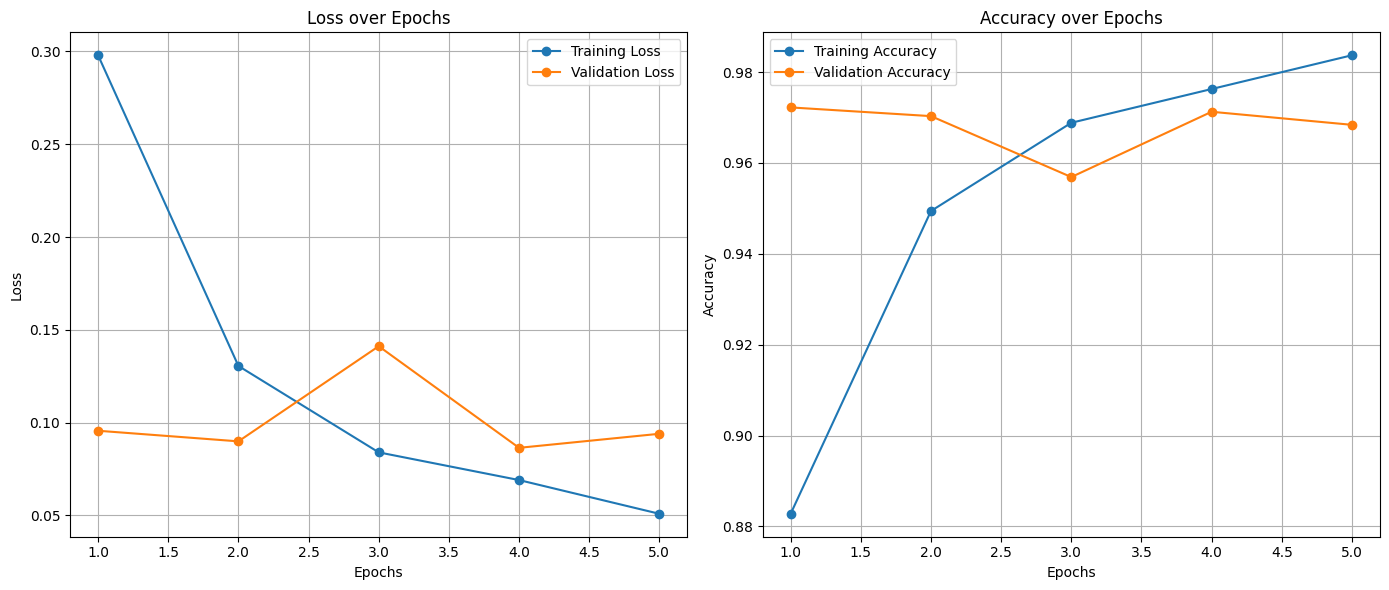

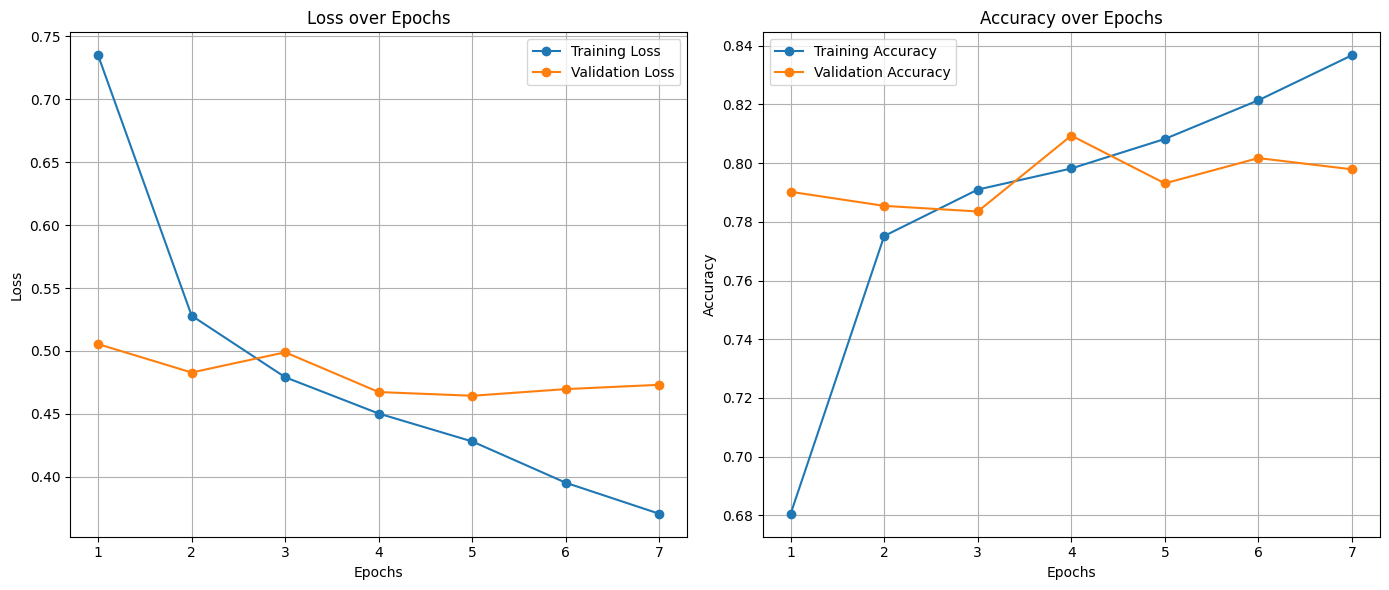

In [ ]:
# ========================================
# Función para graficar histórico
# ========================================
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['loss'], marker='o', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], marker='o', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['accuracy'], marker='o', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], marker='o', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

plot_training_history(history_bin)
plot_training_history(history_tri)


##Tuning de Hiperparametros


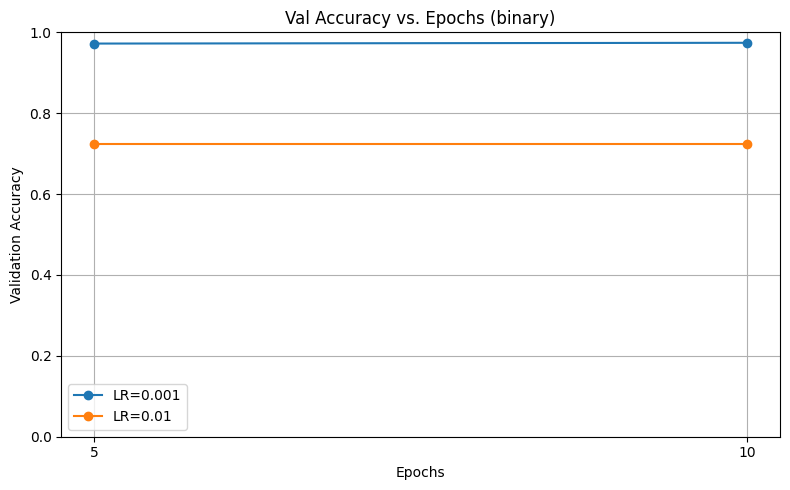

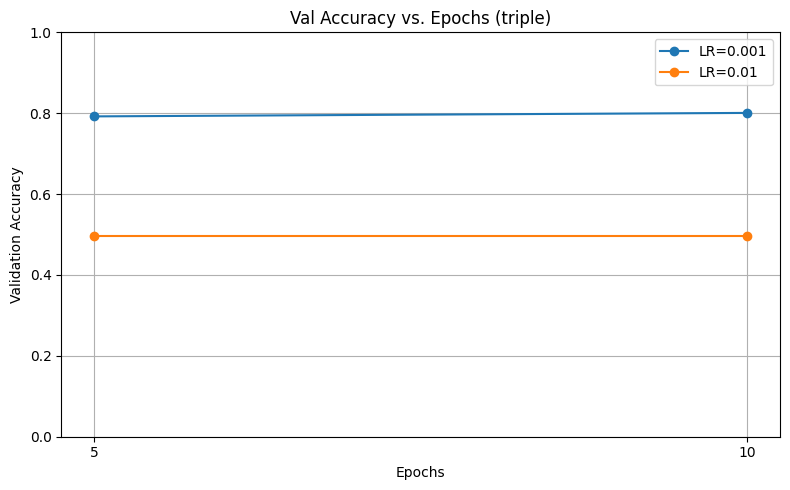

In [ ]:
# ========================================
# Búsqueda de Hiperparámetros
# ========================================
learning_rates = [1e-3, 1e-2]
epoch_list     = [5, 10]
results = []

for model_type in ['binary','triple']:
    for lr in learning_rates:
        for epochs in epoch_list:
            if model_type == 'binary':
                model, ds_tr, ds_va = build_classifier_model(num_classes_binary), ds_train_bin, ds_val_bin
            else:
                model, ds_tr, ds_va = build_classifier_model_subtype(num_classes_triple), ds_train_tri, ds_val_tri

            model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
            hist = model.fit(ds_tr, validation_data=ds_va, epochs=epochs, verbose=0)
            results.append({
                'modelo':        model_type,
                'learning_rate': lr,
                'epochs':        epochs,
                'train_loss':    hist.history['loss'][-1],
                'train_acc':     hist.history['accuracy'][-1],
                'val_loss':      hist.history['val_loss'][-1],
                'val_acc':       hist.history['val_accuracy'][-1]
            })

df_results = pd.DataFrame(results).sort_values(['modelo','learning_rate','epochs'])
#display_dataframe_to_user("Resultados Experimentos Hiperparámetros", df_results)

# ========================================
# Función para graficar comparación
# ========================================
def plot_hyperparam_comparison(df, model_type):
    plt.figure(figsize=(8,5))
    subset = df[df['modelo'] == model_type]
    for lr in sorted(subset['learning_rate'].unique()):
        df_lr = subset[subset['learning_rate'] == lr]
        plt.plot(df_lr['epochs'], df_lr['val_acc'], marker='o', label=f"LR={lr}")
    plt.title(f"Val Accuracy vs. Epochs ({model_type})")
    plt.xlabel("Epochs"); plt.ylabel("Validation Accuracy")
    plt.xticks(epoch_list); plt.ylim(0,1)
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plot_hyperparam_comparison(df_results, 'binary')
plot_hyperparam_comparison(df_results, 'triple')